In [1]:
%matplotlib inline

In [2]:
import random

from datetime import UTC, datetime
from pathlib import Path

In [3]:
import matplotlib.pyplot as plot
import numpy
import torch

from rich import print as pprint
from rich.progress import Progress
from rich.rule import Rule
from torch import Tensor
from torch.nn import Module, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader

In [4]:
from baikal.common.dataset.arrow import memory_map_dataset
from baikal.ml.torch.dataset import (
    ArrowTimeSeriesBatch,
    ArrowTimeSeriesDataset,
    StrideWindowStrategy,
)
from baikal.ml.torch.models import NLinearIndividual, NLinearUnified

In [5]:
device = (
    torch.accelerator.current_accelerator().type
    if torch.accelerator.is_available()
    else "cpu"
)

pprint(device)

cpu

In [6]:
random.seed(0xDEADBEEF)

torch.manual_seed(0xDEADBEEF)
numpy.random.seed(0xDEADBEEF)

In [7]:
DATASET_NAME = "indicators/binance/spot/BTCUSDT"

In [8]:
TRAIN_DATASET_START = datetime(2018, 1, 1, tzinfo=UTC)
TRAIN_DATASET_END = datetime(2025, 1, 1, tzinfo=UTC)

In [9]:
VALIDATION_DATASET_START = datetime(2025, 1, 1, tzinfo=UTC)
VALIDATION_DATASET_END = datetime(2025, 5, 1, tzinfo=UTC)

In [10]:
TEST_DATASET_START = datetime(2025, 5, 1, tzinfo=UTC)
TEST_DATASET_END = datetime(2025, 9, 1, tzinfo=UTC)

In [11]:
EPOCHS = 10
BATCH_SIZE = 256

FEATURE_WINDOW = 300
TARGET_WINDOW = 30
WINDOW_STRIDE = 30

In [12]:
dataset = memory_map_dataset(Path("../data/processed") / DATASET_NAME).to_table()

In [13]:
feature_columns = ["open", "high", "low", "close", "volume"]
target_columns = ["open", "high", "low", "close", "volume"]

open_feature_index = feature_columns.index("open")
volume_feature_index = feature_columns.index("volume")

open_target_index = target_columns.index("open")
volume_target_index = target_columns.index("volume")

In [14]:
train_windows = StrideWindowStrategy(
    dataset,
    "date_time",
    frequency="1m",
    feature_window=FEATURE_WINDOW,
    target_window=TARGET_WINDOW,
    stride=WINDOW_STRIDE,
    start=TRAIN_DATASET_START,
    end=TRAIN_DATASET_END,
)

train_dataset = ArrowTimeSeriesDataset(
    dataset,
    train_windows,
    feature_window=FEATURE_WINDOW,
    target_window=TARGET_WINDOW,
    features=feature_columns,
    targets=target_columns,
)

pprint("Train dataset length: ", len(train_dataset))

Train dataset length:  120575

In [15]:
validation_windows = StrideWindowStrategy(
    dataset,
    "date_time",
    frequency="1m",
    feature_window=FEATURE_WINDOW,
    target_window=TARGET_WINDOW,
    stride=WINDOW_STRIDE,
    start=VALIDATION_DATASET_START,
    end=VALIDATION_DATASET_END,
)

validation_dataset = ArrowTimeSeriesDataset(
    dataset,
    validation_windows,
    feature_window=FEATURE_WINDOW,
    target_window=TARGET_WINDOW,
    features=feature_columns,
    targets=target_columns,
)

pprint("Validation dataset length: ", len(validation_dataset))

Validation dataset length:  5750

In [16]:
test_windows = StrideWindowStrategy(
    dataset,
    "date_time",
    frequency="1m",
    feature_window=FEATURE_WINDOW,
    target_window=TARGET_WINDOW,
    stride=WINDOW_STRIDE,
    start=TEST_DATASET_START,
    end=TEST_DATASET_END,
)

test_dataset = ArrowTimeSeriesDataset(
    dataset,
    test_windows,
    feature_window=FEATURE_WINDOW,
    target_window=TARGET_WINDOW,
    features=feature_columns,
    targets=target_columns,
)

pprint("Test dataset length: ", len(test_dataset))

Test dataset length:  5894

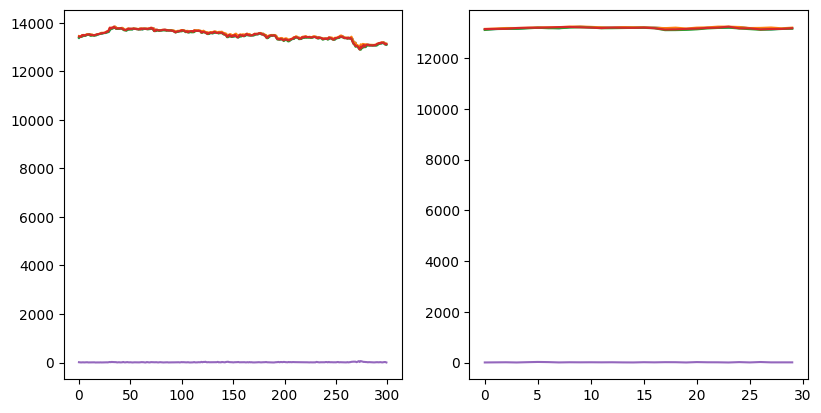

In [17]:
sample = train_dataset[0]

figure, (feature_axe, target_axe) = plot.subplots(1, 2, figsize=(9.6, 4.8))

for name, feature in zip(
    sample.features.schema.names, sample.features.itercolumns(), strict=False
):
    feature_axe.plot(feature.to_numpy(), label=name)

for name, target in zip(
    sample.targets.schema.names, sample.targets.itercolumns(), strict=False
):
    target_axe.plot(target.to_numpy(), label=name)

figure.subplots_adjust(wspace=0.2)

In [18]:
train_dataloader = DataLoader(
    train_dataset,
    BATCH_SIZE,
    collate_fn=ArrowTimeSeriesBatch.from_samples,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
)
validation_dataloader = DataLoader(
    validation_dataset,
    BATCH_SIZE,
    collate_fn=ArrowTimeSeriesBatch.from_samples,
    pin_memory=True,
)
test_dataloader = DataLoader(
    test_dataset,
    BATCH_SIZE,
    collate_fn=ArrowTimeSeriesBatch.from_samples,
    pin_memory=True,
)

## Utility Functions

In [19]:
def train_epoch(
    dataloader: DataLoader, model: Module, loss_function, optimizer
) -> tuple[float, int]:
    model.train()

    summary_loss = 0
    batch_count = 0

    with Progress(transient=True) as progress:
        tracker = progress.add_task("Training Epoch", total=len(dataloader))

        batch: ArrowTimeSeriesBatch
        for batch in dataloader:
            features = batch.features.to(device, torch.float32)
            targets = batch.targets.to(device, torch.float32)

            prediction = model(features)
            loss = loss_function(prediction, targets)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            summary_loss += loss.item()
            batch_count += 1

            progress.advance(tracker)

    return summary_loss, batch_count

In [20]:
def evaluate(dataloader: DataLoader, model: Module, loss_function) -> tuple[float, int]:
    model.eval()

    summary_loss = 0
    batch_count = 0

    with torch.no_grad(), Progress(transient=True) as progress:
        tracker = progress.add_task("Evaluating", total=len(dataloader))

        batch: ArrowTimeSeriesBatch
        for batch in dataloader:
            features = batch.features.to(device, torch.float32)
            targets = batch.targets.to(device, torch.float32)

            prediction = model(features)
            loss = loss_function(prediction, targets)

            summary_loss += loss.item()
            batch_count += 1

            progress.advance(tracker)

    return summary_loss, batch_count

In [21]:
def plot_predictions(
    batch: ArrowTimeSeriesBatch, prediction_batch: Tensor, count: int
) -> None:
    feature_batch = random_batch.features[:count]
    target_batch = random_batch.targets[:count]
    prediction_batch = prediction_batch[:count]

    for features, targets, predictions in zip(
        feature_batch, target_batch, prediction_batch, strict=False
    ):
        figure, (open_axe, volume_axe) = plot.subplots(1, 2, figsize=(12.8, 4.8))

        open_feature = features[:, open_feature_index]
        open_target = targets[:, open_target_index]
        open_prediction = predictions[:, open_target_index]

        open_axe.plot(
            range(FEATURE_WINDOW + TARGET_WINDOW),
            torch.cat((open_feature, open_target)),
        )

        open_axe.plot(
            range(FEATURE_WINDOW, FEATURE_WINDOW + TARGET_WINDOW),
            open_prediction,
            linestyle="dashed",
        )

        volume_feature = features[:, volume_feature_index]
        volume_target = targets[:, volume_target_index]
        volume_prediction = predictions[:, volume_target_index]

        volume_axe.plot(
            range(FEATURE_WINDOW + TARGET_WINDOW),
            torch.cat((volume_feature, volume_target)),
        )
        volume_axe.plot(
            range(FEATURE_WINDOW, FEATURE_WINDOW + TARGET_WINDOW),
            volume_prediction,
            linestyle="dashed",
        )

        plot.show()

## `NLinear` with Unified Weights

### Initialization

In [22]:
unified_model = NLinearUnified(FEATURE_WINDOW, TARGET_WINDOW).to(device)
loss_function = MSELoss(reduction="mean")
optimizer = Adam(unified_model.parameters())

### Training

In [25]:
for epoch in range(EPOCHS):
    pprint(Rule(f"Epoch {epoch}", align="left"))
    train_summary_loss, train_batch_count = train_epoch(
        train_dataloader, unified_model, loss_function, optimizer
    )
    eval_summary_loss, eval_batch_count = evaluate(
        test_dataloader, unified_model, loss_function
    )

    pprint(
        f"Mean train score: {train_summary_loss / train_batch_count:>7f}, on {train_batch_count} batches."
    )
    pprint(
        f"Mean eval score: {eval_summary_loss / eval_batch_count:>7f}, on {eval_batch_count} batches."
    )

Epoch 0 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

/home/zitrasa/baikal/baikal-ml/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 
'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)

Output()

Mean train score: 15792.804272, on 470 batches.

Mean eval score: 39500.726766, on 24 batches.

Epoch 1 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 15029.154107, on 470 batches.

Mean eval score: 34254.123698, on 24 batches.

Epoch 2 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 15205.579558, on 470 batches.

Mean eval score: 35534.148560, on 24 batches.

Epoch 3 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14982.676199, on 470 batches.

Mean eval score: 33971.092855, on 24 batches.

Epoch 4 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14885.474358, on 470 batches.

Mean eval score: 34018.382039, on 24 batches.

Epoch 5 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14817.342916, on 470 batches.

Mean eval score: 35960.993490, on 24 batches.

Epoch 6 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14634.786848, on 470 batches.

Mean eval score: 35997.154012, on 24 batches.

Epoch 7 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14780.284532, on 470 batches.

Mean eval score: 34374.699829, on 24 batches.

Epoch 8 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14765.628242, on 470 batches.

Mean eval score: 36976.294800, on 24 batches.

Epoch 9 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14726.332534, on 470 batches.

Mean eval score: 37160.627767, on 24 batches.

In [26]:
torch.save(unified_model.state_dict(), Path("../models/nlinear-unified.pth"))

### Results Visualization

In [23]:
unified_model.load_state_dict(torch.load(Path("../models/nlinear-unified.pth")))

<All keys matched successfully>

In [26]:
random_batch = next(iter(test_dataloader))

unified_model.eval()
with torch.no_grad():
    prediction_batch = unified_model(random_batch.features.to(device, torch.float32))

pprint(f"Predictions shape: {prediction_batch.shape}")

Predictions shape: torch.Size([256, 30, 5])

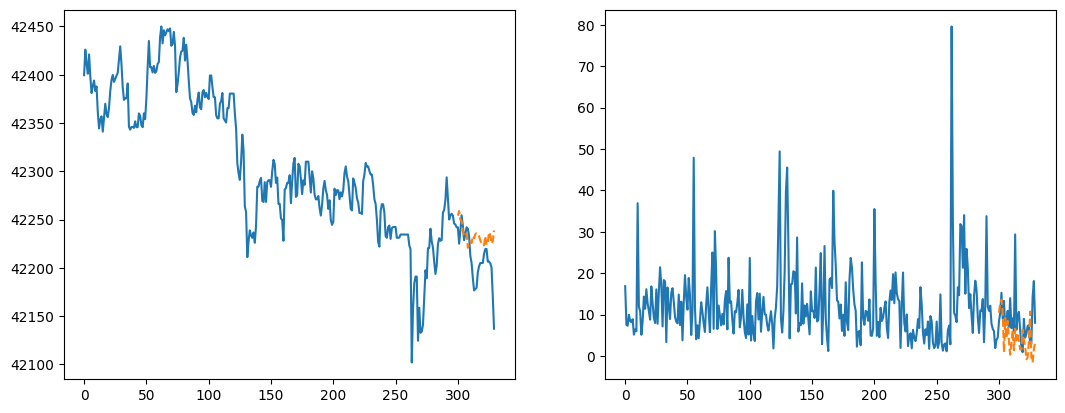

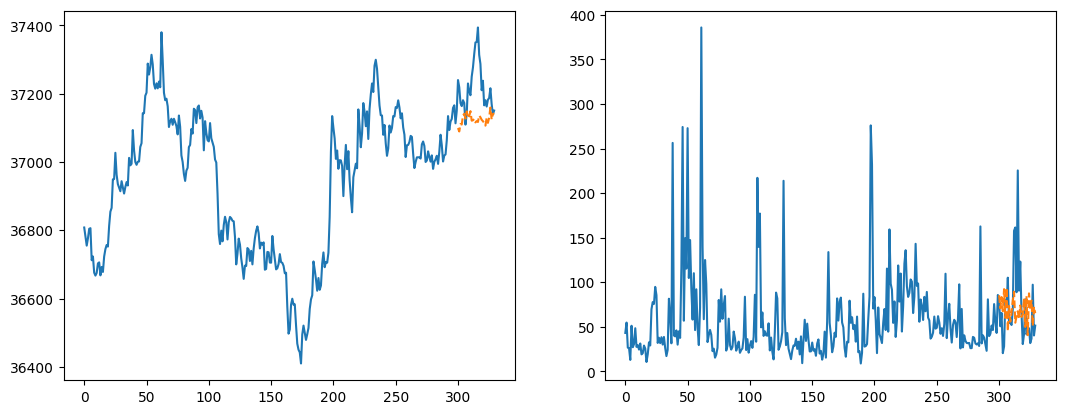

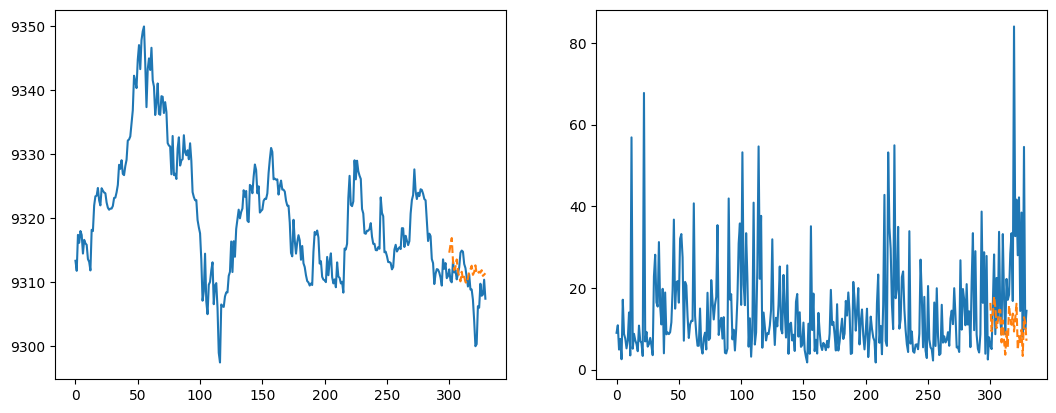

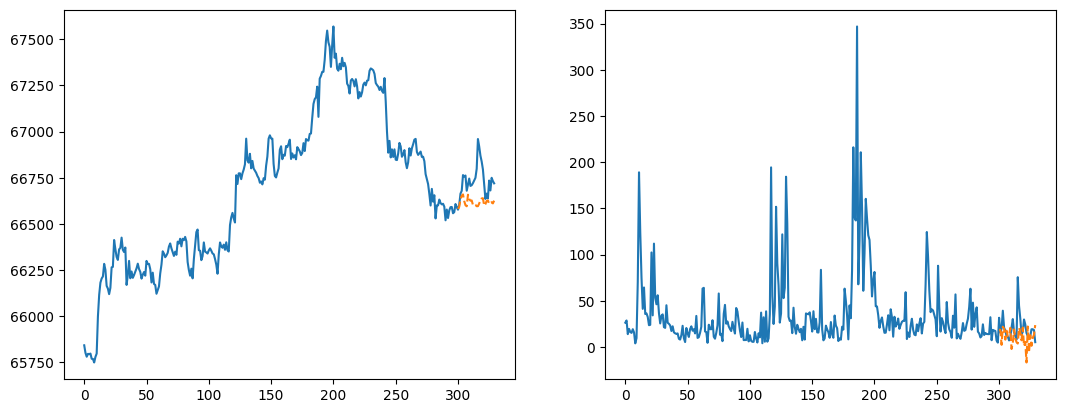

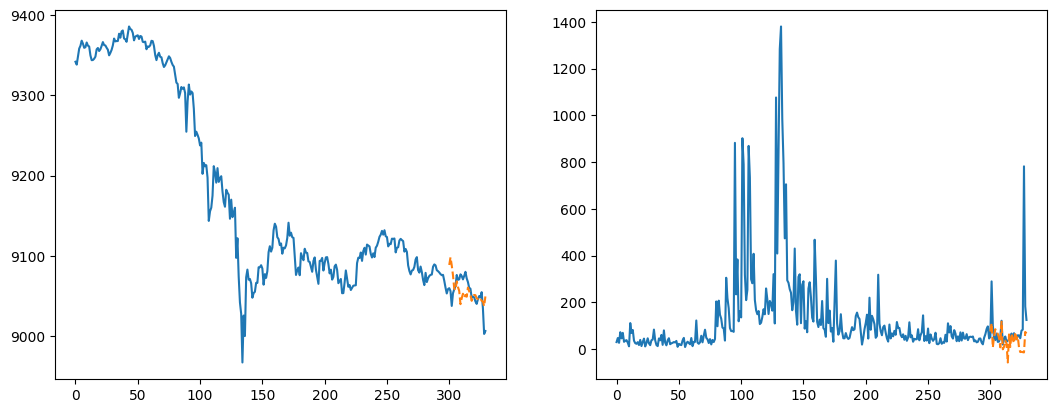

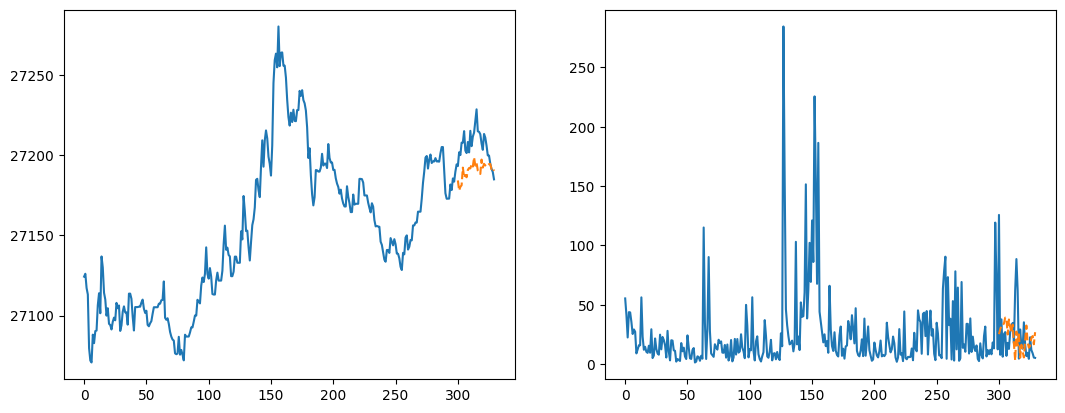

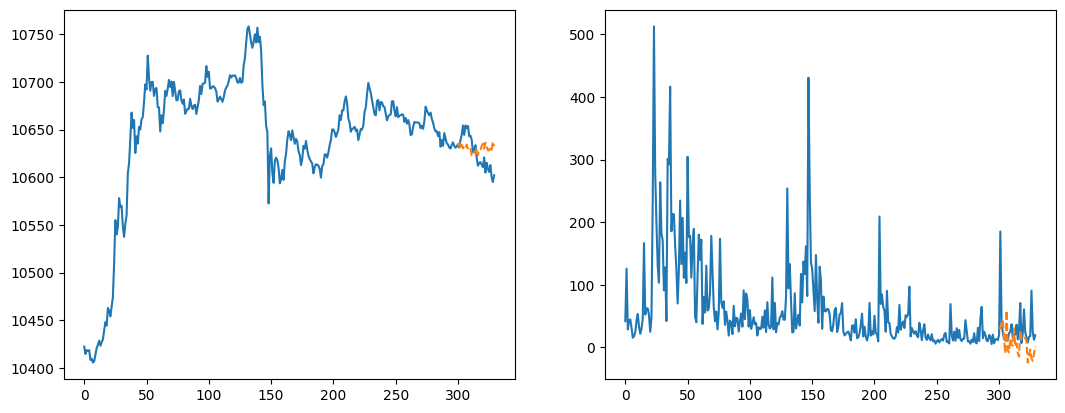

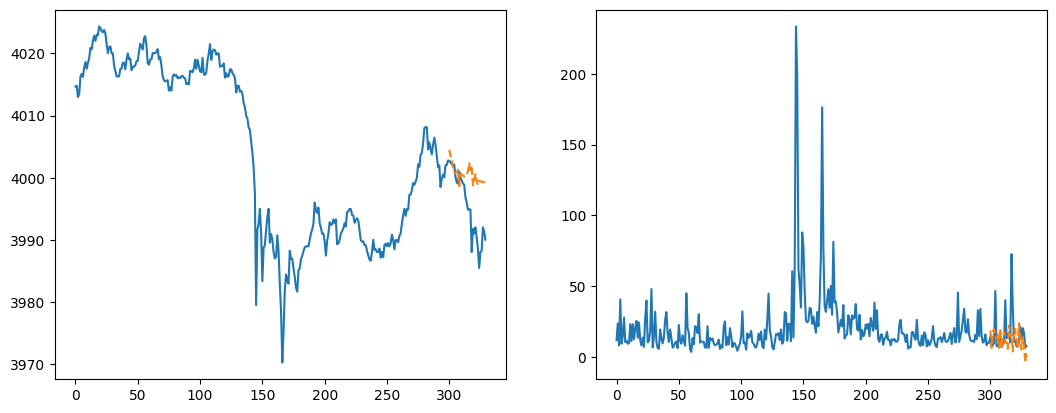

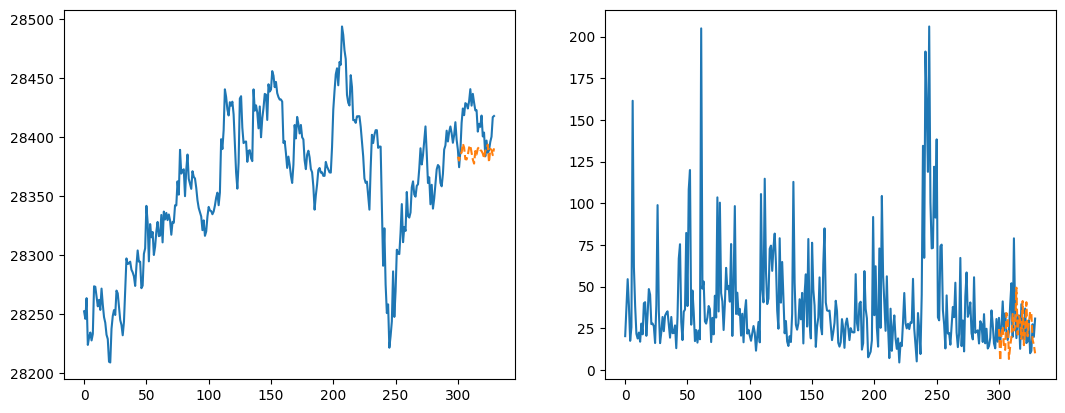

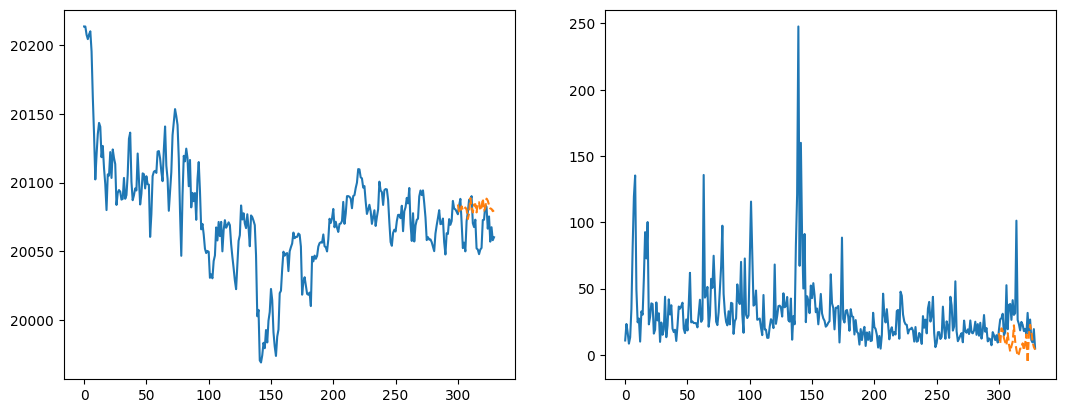

In [30]:
plot_predictions(random_batch, prediction_batch, 10)

## `NLinear` with Individual Weights

### Initialization

In [30]:
assert len(feature_columns) == len(target_columns)

individual_model = NLinearIndividual(
    FEATURE_WINDOW, TARGET_WINDOW, len(target_columns)
).to(device)
loss_function = MSELoss(reduction="mean")
optimizer = Adam(individual_model.parameters())

In [25]:
for epoch in range(EPOCHS):
    pprint(Rule(f"Epoch {epoch}", align="left"))
    train_summary_loss, train_batch_count = train_epoch(
        train_dataloader, individual_model, loss_function, optimizer
    )
    eval_summary_loss, eval_batch_count = evaluate(
        test_dataloader, individual_model, loss_function
    )

    pprint(
        f"Mean train score: {train_summary_loss / train_batch_count:>7f}, on {train_batch_count} batches."
    )
    pprint(
        f"Mean eval score: {eval_summary_loss / eval_batch_count:>7f}, on {eval_batch_count} batches."
    )

Epoch 0 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

/home/zitrasa/baikal/baikal-ml/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 
'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)

Output()

Mean train score: 15508.990383, on 470 batches.

Mean eval score: 36659.525391, on 24 batches.

Epoch 1 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14643.414244, on 470 batches.

Mean eval score: 34333.863444, on 24 batches.

Epoch 2 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14604.973396, on 470 batches.

Mean eval score: 34424.219198, on 24 batches.

Epoch 3 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14424.481132, on 470 batches.

Mean eval score: 34913.108317, on 24 batches.

Epoch 4 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14559.092740, on 470 batches.

Mean eval score: 34802.523844, on 24 batches.

Epoch 5 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14554.924304, on 470 batches.

Mean eval score: 34138.843953, on 24 batches.

Epoch 6 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14312.339811, on 470 batches.

Mean eval score: 36720.392700, on 24 batches.

Epoch 7 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14352.821535, on 470 batches.

Mean eval score: 34002.805094, on 24 batches.

Epoch 8 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14447.520401, on 470 batches.

Mean eval score: 34218.398926, on 24 batches.

Epoch 9 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14676.285443, on 470 batches.

Mean eval score: 38962.344116, on 24 batches.

In [26]:
torch.save(individual_model.state_dict(), Path("../models/nlinear-individual.pth"))

### Results Visualization

In [31]:
individual_model.load_state_dict(torch.load(Path("../models/nlinear-individual.pth")))

<All keys matched successfully>

In [32]:
random_batch = next(iter(test_dataloader))

individual_model.eval()
with torch.no_grad():
    prediction_batch = individual_model(random_batch.features.to(device, torch.float32))

pprint(f"Predictions shape: {prediction_batch.shape}")

Predictions shape: torch.Size([256, 30, 5])

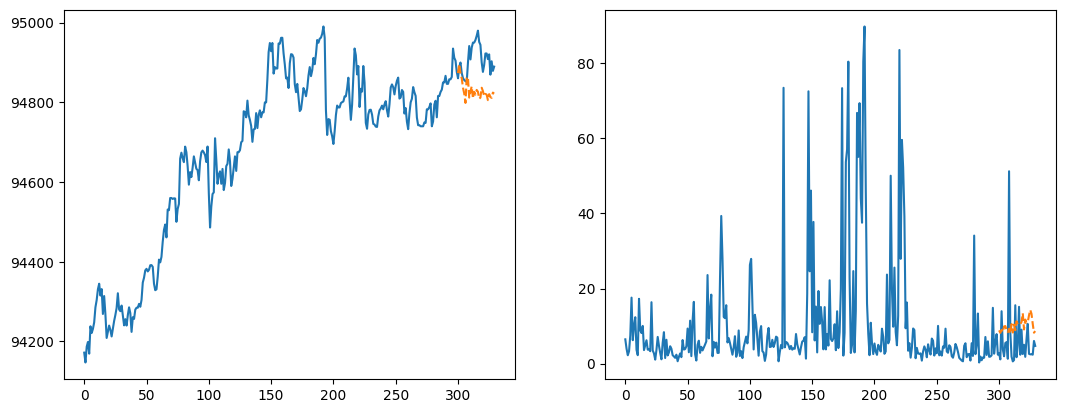

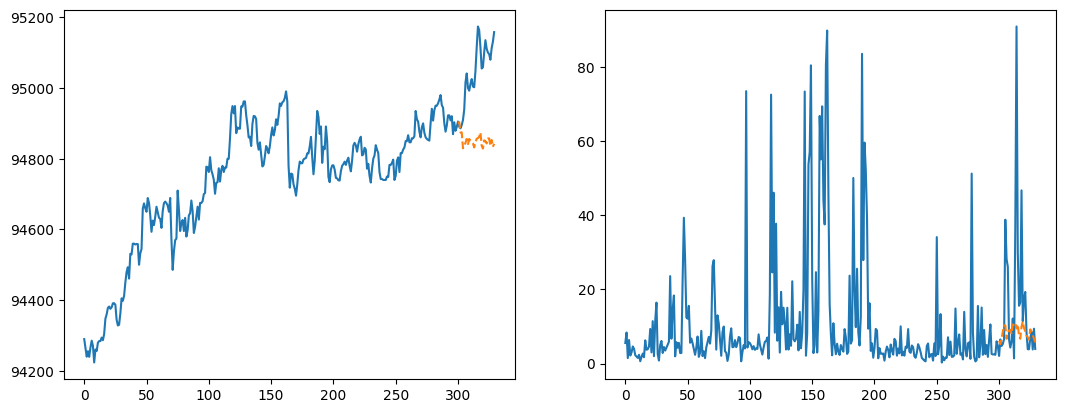

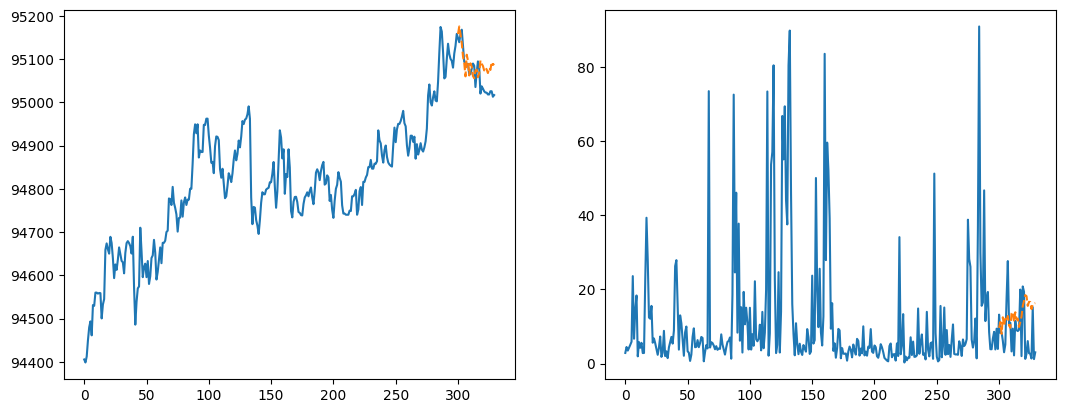

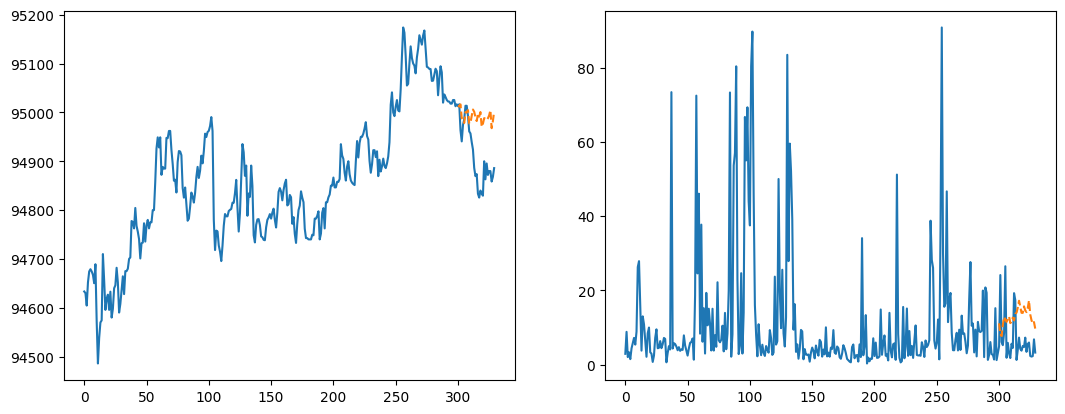

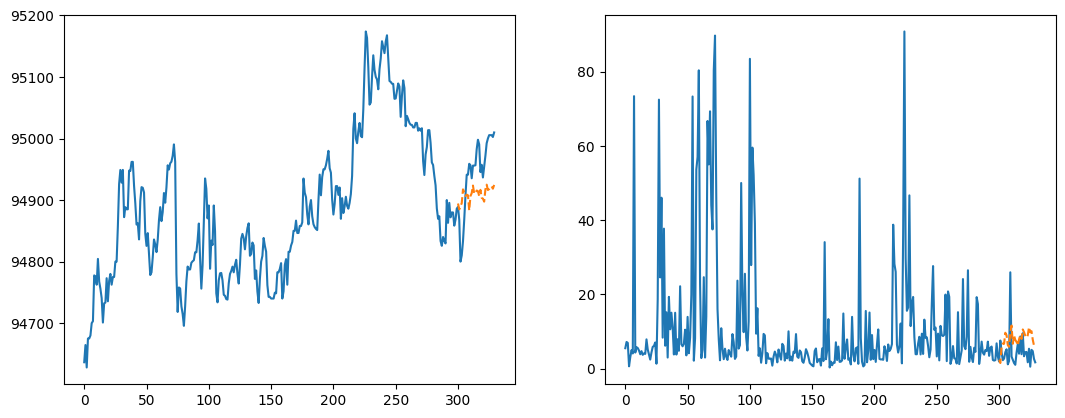

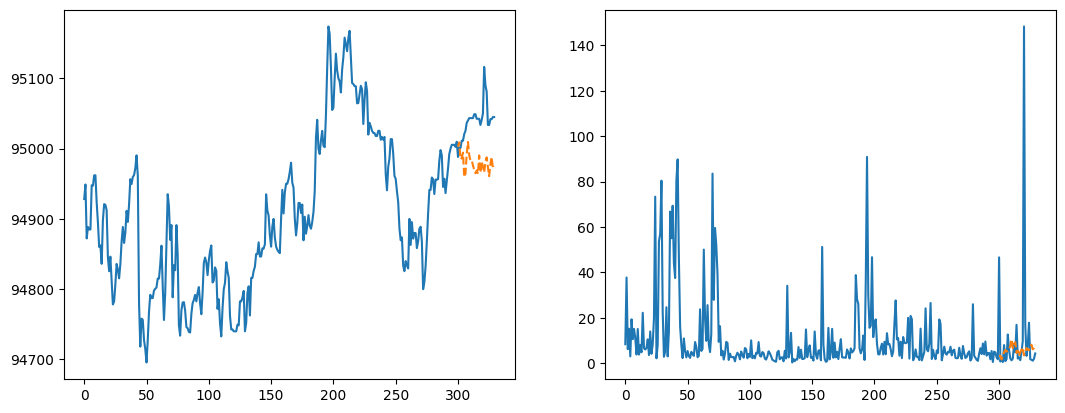

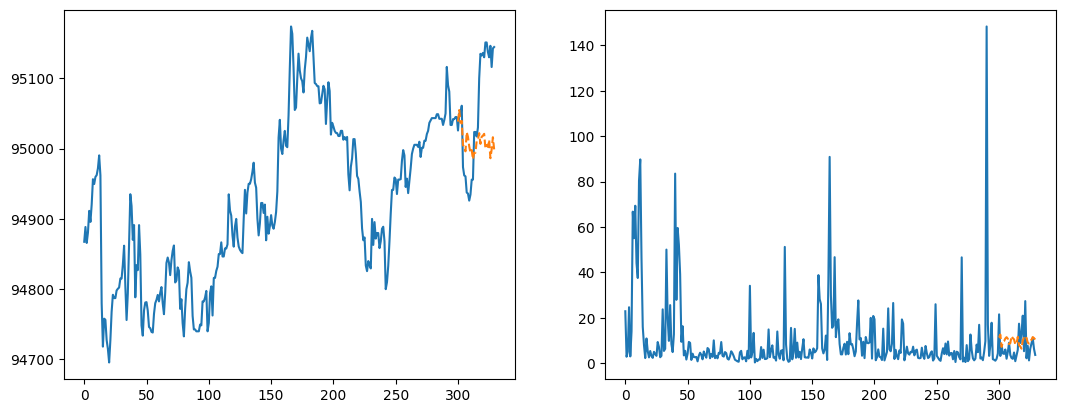

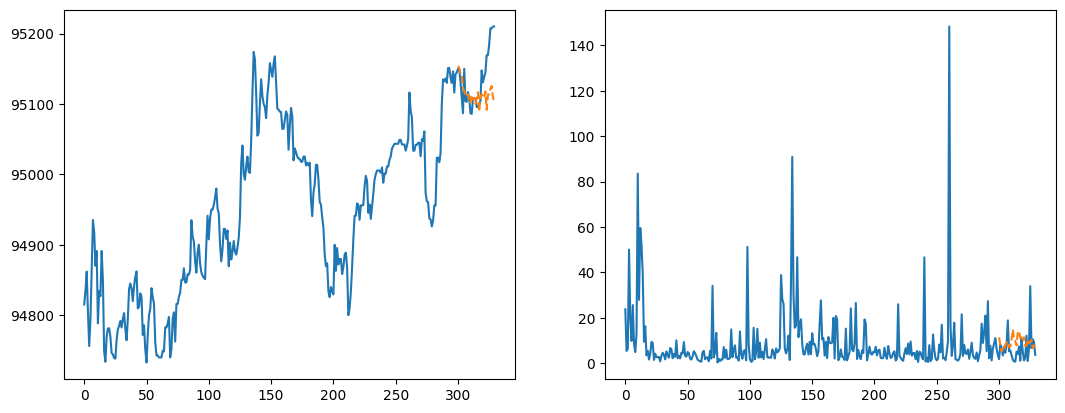

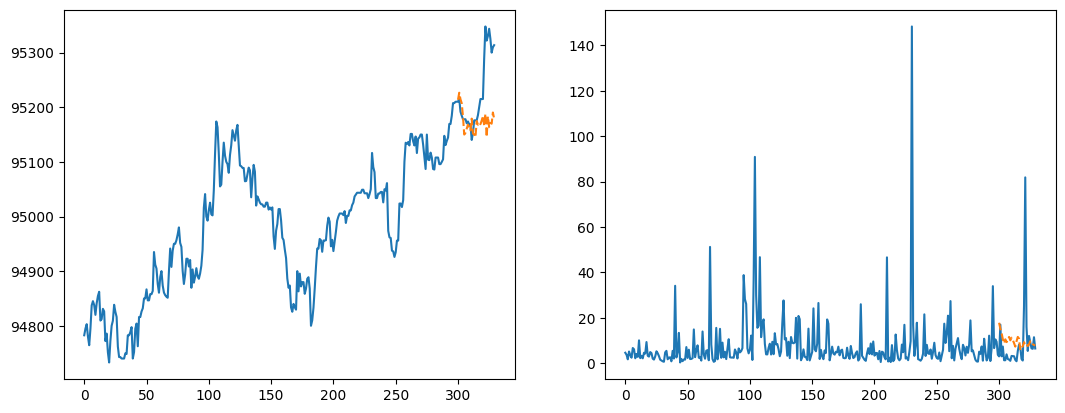

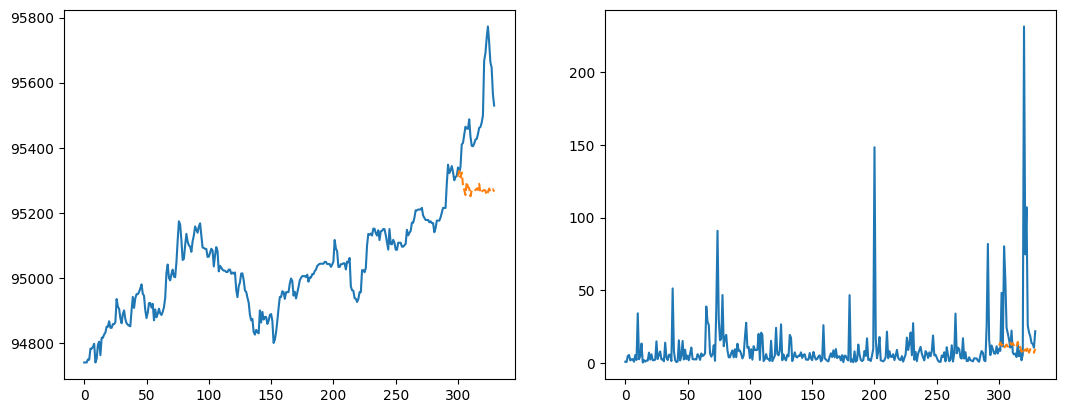

In [33]:
plot_predictions(random_batch, prediction_batch, 10)